In [1]:
import numpy as np
import csv
import glob
import os.path
from os import path
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
import talib

In [7]:
# The basic CSV instrument. We'll abstract this later when we need it
class FileInstrument:
    def __init__(self, filename, load=True):
        self.datetime_format = '%d-%b-%Y'
        self.column_names = ['day', 'month', 'year', 'open', 'high', 'low', 'close', 'volume', 'forward_returns']
        self.column_set = set(self.column_names)
        
        self.data = None
        
        if load:
            self.load_file(filename)
        
    def load_file(self, filename):
        with open(filename) as f:
            item = []
            reader = csv.reader(f)
            for row in reader:
                _row = self.format_row(*row)
                item.append(_row)
                
        item = np.array(item)
        returns = np.expand_dims(np.diff(item[:,-2], append=item[:,-2][-1]), axis=1)
        
        items_with_returns = np.hstack((item, returns))
        self.data = items_with_returns
        
    def format_row(self, *args):
        date = datetime.strptime(args[0], self.datetime_format)
        o = float(args[1])
        h = float(args[2])
        l = float(args[3])
        c = float(args[4])
        v = int(args[5])

        return [date.day, date.month, date.year, o, h, l, c, v]
    
    def attach_feature(self, feature, name):
        self.column_set.add(name) # this will fail if the feature already exists
        self.column_names.append(name)
        
        f = np.expand_dims(feature, axis=1)
        self.data = np.hstack((self.data, f))
    
    def __getitem__(self, key):
        if type(key) == str:
            idx = self.column_names.index(key)
            return self.data[:,idx]
        
        return self.data.__getitem__(key)

    def __repr__(self):
        return self.data.__repr__()

In [8]:
luv = FileInstrument('../../../Developer/Data/prices/NYSE/LUV.csv')

In [9]:
d = np.diff(luv['close'], prepend=luv['close'][0])

In [10]:
luv.attach_feature(d, 'back_returns')

In [11]:
luv['back_returns']

array([ 0.  , -0.29, -0.04, ...,  0.16,  0.08, -0.07])

In [12]:
def run_monte_single(asset, idx, samples=1000, simulations=1000):
    returns = asset['forward_returns'][idx]
    mcs = np.stack([np.cumsum(np.random.choice(returns, samples)) for i in range(simulations)])
    return mcs

In [13]:
mc = run_monte_single(luv, luv['close'] > talib.EMA(luv['close'], timeperiod=100), samples=50000)

In [14]:
plt.plot(mc.T, alpha=0.01)

Error in callback <function flush_figures at 0x7fc110707048> (for post_execute):


KeyboardInterrupt: 

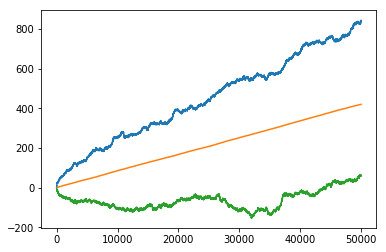

In [15]:
plt.plot(np.max(mc, axis=0))
plt.plot(np.mean(mc, axis=0))
plt.plot(np.min(mc, axis=0))

In [16]:
aapl = FileInstrument('../../../Developer/Data/prices/NASDAQ/AAPL.csv')

In [17]:
d = np.diff(aapl['close'], prepend=aapl['close'][0])
aapl.attach_feature(d, 'back_returns')

In [18]:
mc = run_monte_single(aapl, aapl['back_returns'] > talib.EMA(aapl['back_returns'], timeperiod=100))

In [19]:
vanilla = run_monte_single(aapl, np.random.choice([True, False], size=len(aapl[:,0]), p=[1, 0]))

(array([ 2.,  1.,  0.,  0.,  2.,  0.,  0.,  3.,  7.,  5.,  6., 12., 15.,
        20., 21., 26., 30., 26., 42., 32., 41., 42., 46., 50., 62., 53.,
        45., 56., 52., 35., 47., 35., 40., 27., 29., 30., 16.,  8.,  7.,
         9.,  5.,  5.,  3.,  1.,  2.,  3.,  0.,  0.,  0.,  1.]),
 array([-61.4779  , -55.555714, -49.633528, -43.711342, -37.789156,
        -31.86697 , -25.944784, -20.022598, -14.100412,  -8.178226,
         -2.25604 ,   3.666146,   9.588332,  15.510518,  21.432704,
         27.35489 ,  33.277076,  39.199262,  45.121448,  51.043634,
         56.96582 ,  62.888006,  68.810192,  74.732378,  80.654564,
         86.57675 ,  92.498936,  98.421122, 104.343308, 110.265494,
        116.18768 , 122.109866, 128.032052, 133.954238, 139.876424,
        145.79861 , 151.720796, 157.642982, 163.565168, 169.487354,
        175.40954 , 181.331726, 187.253912, 193.176098, 199.098284,
        205.02047 , 210.942656, 216.864842, 222.787028, 228.709214,
        234.6314  ]),
 <a list of 50

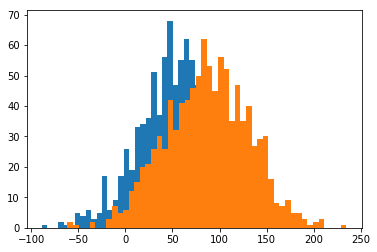

In [20]:
plt.hist(vanilla[:,-1], bins=50)
plt.hist(mc[:,-1], bins=50)

In [21]:
strat = aapl['close'] > talib.EMA(aapl['close'], timeperiod=100)

In [22]:
performance = strat.astype(int) * aapl['forward_returns']

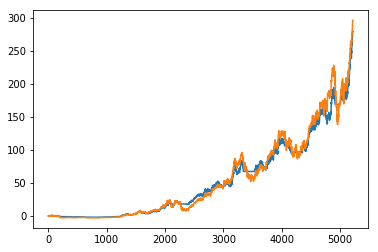

In [23]:
plt.plot(np.cumsum(performance))
plt.plot(np.cumsum(aapl['forward_returns']))

In [24]:
time_in_market = np.sum(strat.astype(int)) / len(strat)

In [25]:
strat_perf = np.cumsum(performance)
buy_hold_perf = np.cumsum(aapl['forward_returns'])

In [26]:
strat_v_bh = strat_perf[-1] / buy_hold_perf[-1]

In [27]:
print(f'Time in the market: \t\t{time_in_market*100:.2f}%')
print(f'Performance against BH: \t{strat_v_bh*100:.2f}%')
print(f'Volatility efficiency: \t\t{(strat_v_bh / time_in_market)*100:.2f}%')

Time in the market: 		68.75%
Performance against BH: 	94.38%
Volatility efficiency: 		137.28%


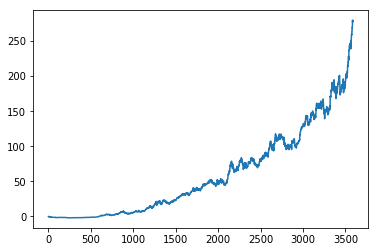

In [28]:
plt.plot(np.cumsum(aapl['forward_returns'][strat]))

In [29]:
from statsmodels.stats.weightstats import ttest_ind

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:
ttest_ind(mc[:,-1], vanilla[:,-1])

(14.414238616663766, 6.929175738875444e-45, 1998.0)

In [31]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.997):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [32]:
mean_confidence_interval(mc[:,-1])

(87.21097849999994, 83.05690396376419, 91.3650530362357)

In [33]:
mean_confidence_interval(vanilla[:,-1])

(58.89448689999999, 54.783436976434295, 63.005536823565684)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc05c7a5f98>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc05c7b0668>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc05c7a5e10>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc05c7b0cf8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc05c7bc080>,
 'means': []}

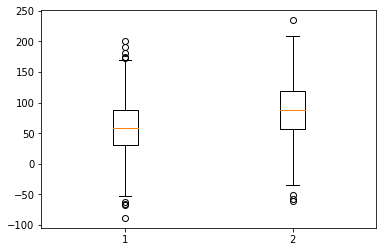

In [34]:
plt.boxplot((vanilla[:,-1], mc[:,-1]))

In [35]:
scipy.stats.ttest_ind(mc[:,-1], vanilla[:,-1])

Ttest_indResult(statistic=14.414238616663752, pvalue=6.929175738876631e-45)

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 7.000e+00,
        9.000e+00, 8.000e+00, 7.000e+00, 1.800e+01, 2.600e+01, 4.000e+01,
        4.900e+01, 7.700e+01, 1.340e+02, 3.060e+02, 8.660e+02, 2.544e+03,
        4.900e+02, 2.550e+02, 1.280e+02, 7.000e+01, 5.400e+01, 3.300e+01,
        1.800e+01, 1.800e+01, 7.000e+00, 8.000e+00, 1.400e+01, 4.000e+00,
        6.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00]),
 array([-15.73  , -15.1912, -14.6524, -14.1136, -13.5748, -13.036 ,
        -12.4972, -11.9584, -11.4196, -10.8808, -10.342 ,  -9.8032,
         -9.2644,  -8.7256,  -8.1868,  -7.648 ,  -7.1092,  -6.5704,
         -6.0316,  -5.4928,  -4.954 ,  -4.4152,  -3.8764,  -3.3376,
         -2.7988,  -2.26  ,  -1.7212,  -1.1824,  -0.6436,  -0.1048,
          0.434 ,   0.9728,   1.5116

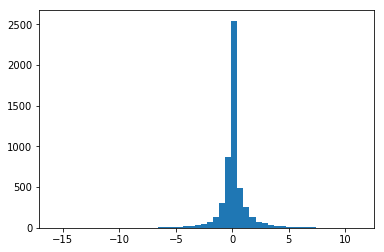

In [36]:
plt.hist(aapl['forward_returns'], bins=50)

In [37]:
import inspect

In [38]:
luv['close'] > talib.EMA(luv['close'])

array([False, False, False, ..., False, False, False])

In [45]:
f = inspect.currentframe()

In [48]:
f.f_code

'<code object <module> at 0x7fc059b4c5d0, file "<ipython-input-45-5abb16185f48>", line 1>'